# XY - Modell

In [1]:
# Standard imports for computational physics
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
from scipy.odr import ODR, RealData, Model
import scienceplots

# Pretty styling for graphs
plt.style.use(['science', 'grid', 'scatter'])
plt.rcParams["figure.figsize"] = (12, 8)

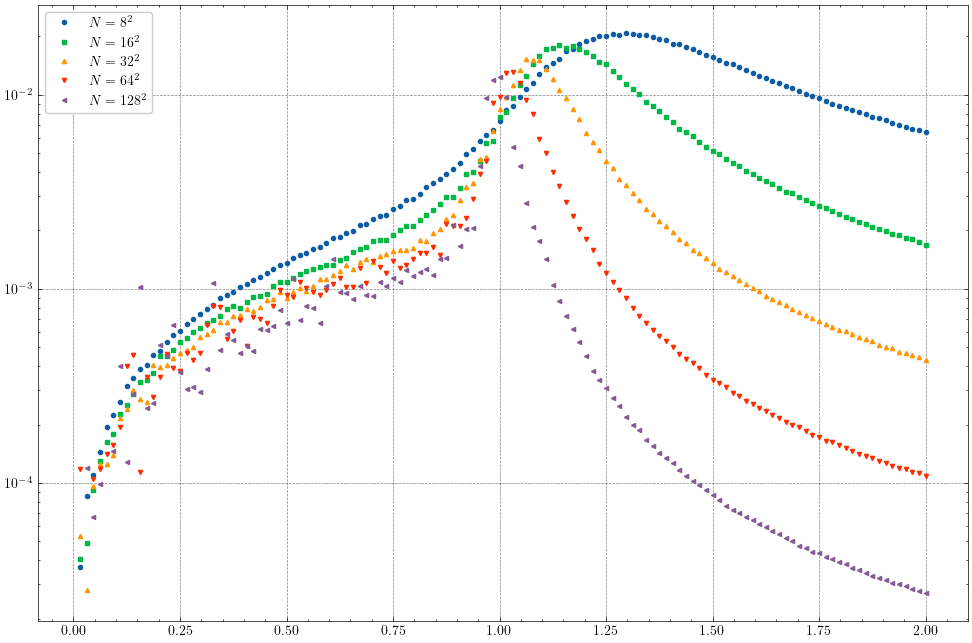

In [7]:
critical_temperature = 0.89213

def power(b: List[float], x: List[float]) -> List[float]:
    return np.array([(b[2]*(np.abs(v - b[0])**(-b[1]) + b[3]) if v > critical_temperature else (b[2]*(v - b[0])**(-b[1]) + b[3])) for v in x])

con = sqlite3.connect('output.sqlite')
current_run = pd.read_sql_query('SELECT id FROM runs ORDER BY created_at DESC', con).at[0, 'id']

sizes = []
maximas = []
delta_maximas = []

fig, ax = plt.subplots()
for size in pd.read_sql_query(f'SELECT size FROM configurations WHERE run_id = \'{current_run}\' GROUP BY size', con)['size']:
    data = pd.read_sql_query(f'SELECT * FROM configurations WHERE run_id = \'{current_run}\' AND size = \'{size}\' ORDER BY temperature', con)
    ax.errorbar(data['temperature'], data['magnet_suscept'], label=f'$N = {size}^2$')

    max_idx = data['magnet_suscept'].idxmax()

    sizes.append(size)
    maximas.append(data.loc[max_idx]['temperature'])
    delta_maximas.append(np.abs(data.loc[max_idx]['temperature'] - data.loc[max_idx + 1]['temperature']))

ax.set_yscale('log')
#ax.set_xlim([0.75, 1.75])
ax.legend()
fig.savefig('Energy.pdf', bbox_inches='tight')

0.936 +- 0.003


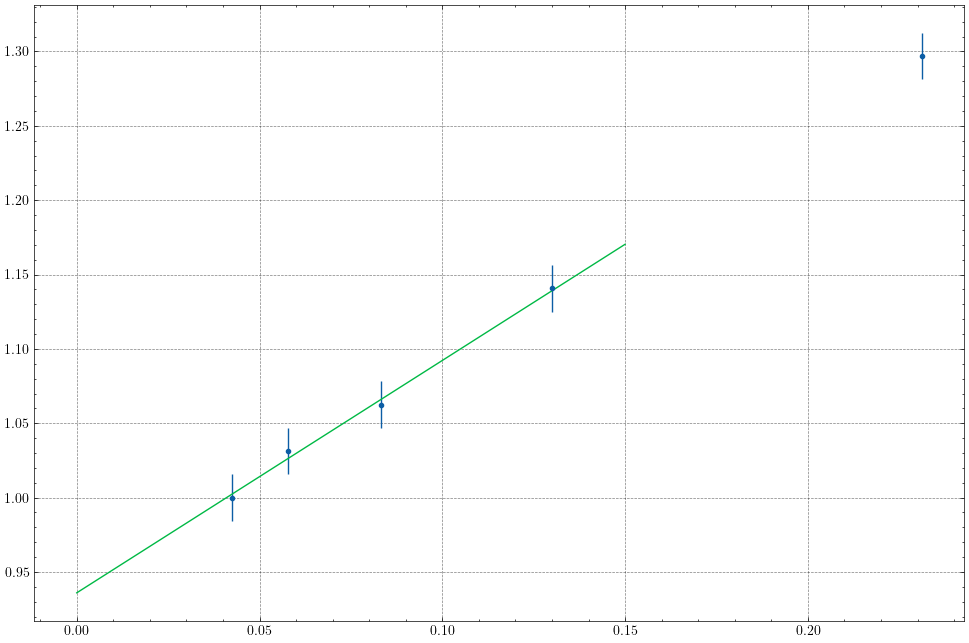

In [8]:
sizes = np.array(sizes)
maximas = np.array(maximas)
delta_maximas = np.array(delta_maximas)

def linear(b: List[float], x: float) -> float:
    return b[0] * x + b[1]

model = Model(linear)
data = RealData(1.0 / np.log(sizes)**2, maximas, sy=delta_maximas)
output = ODR(data, model, beta0=[0, 0.89]).run()
print(f'{output.beta[1]:.3f} +- {output.sd_beta[1]:.3f}')

fig, ax = plt.subplots()
ax.errorbar(1.0 / np.log(sizes)**2, maximas, yerr=delta_maximas)

sampling = np.linspace(0, 0.15, num=100)
ax.plot(sampling, linear(output.beta, sampling), '-')